In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt
from scipy import stats

df = pd.read_csv("FINAL_DATA.csv")

In [2]:
# Quick check
print(df.head())
print(df.dtypes)

  Country.of.Origin  Number.of.Bags  Bag.Weight  Harvest.Year Grading.Date  \
0          Thailand               1          10          2020   2024-10-29   
1          Thailand               1           8          2025   2025-07-08   
2          Thailand               1           7          2025   2025-10-02   
3          Thailand               1           8          2025   2025-08-26   
4          Thailand               1           7          2021   2025-10-02   

  Processing.Method  Aroma  Flavor  Aftertaste  Acidity  ...  Clean.Cup  \
0        Washed/Wet   8.67    8.50        8.33     8.00  ...       10.0   
1       Natural/Dry   8.25    8.50        8.33     8.25  ...       10.0   
2       Natural/Dry   8.42    8.42        8.17     8.17  ...       10.0   
3       Natural/Dry   8.25    8.33        8.25     8.17  ...       10.0   
4        Washed/Wet   8.33    8.25        8.08     8.08  ...       10.0   

   Sweetness  Moisture  Category.One.Defects  Quakers   Color  \
0       10.0   

In [3]:
# Define features (X) and target (y)
target_col = "Altitude"
X = df.drop(columns=[target_col])
y = df[target_col]

# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(exclude=[np.number]).columns.tolist()

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)

Numeric features: ['Number.of.Bags', 'Bag.Weight', 'Harvest.Year', 'Aroma', 'Flavor', 'Aftertaste', 'Acidity', 'Body', 'Balance', 'Uniformity', 'Clean.Cup', 'Sweetness', 'Moisture', 'Category.One.Defects', 'Quakers', 'Category.Two.Defects']
Categorical features: ['Country.of.Origin', 'Grading.Date', 'Processing.Method', 'Color', 'Expiration', 'Species']


## Exploratory Scatterplots - CAN CHANGE NUMERIC FEATURES THAT ARE INPUTTED! 

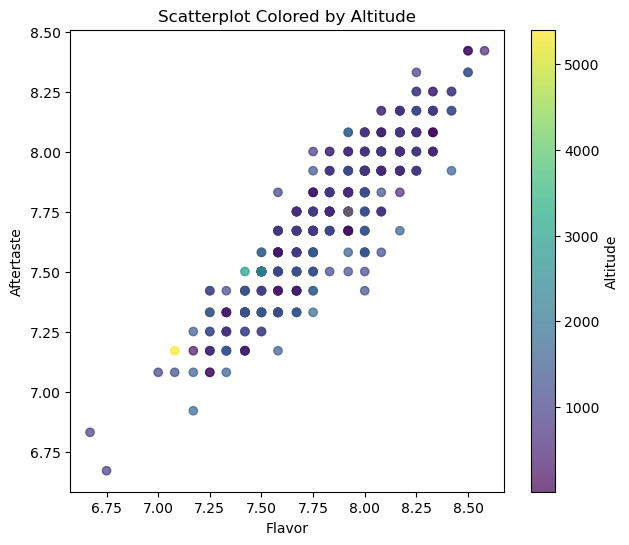

In [4]:
plt.figure(figsize=(7, 6))
plt.scatter(df["Flavor"], df["Aftertaste"], 
            c=df["Altitude"], cmap="viridis", alpha=0.7)
plt.colorbar(label="Altitude")
plt.xlabel("Flavor")
plt.ylabel("Aftertaste")
plt.title("Scatterplot Colored by Altitude")
plt.show()


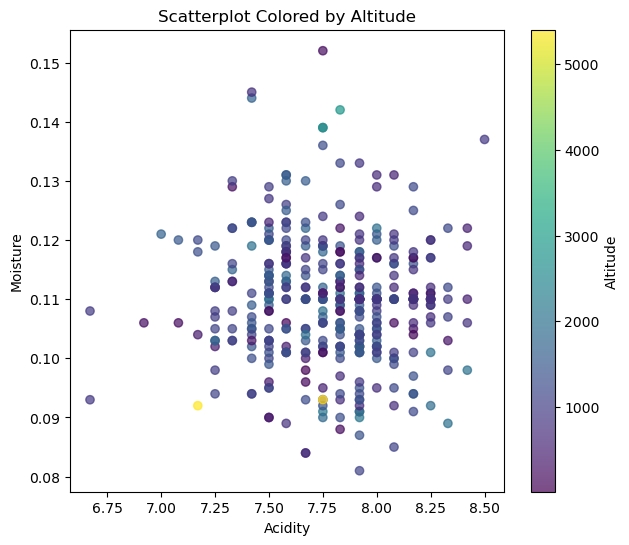

In [5]:
plt.figure(figsize=(7, 6))
plt.scatter(df["Acidity"], df["Moisture"], 
            c=df["Altitude"], cmap="viridis", alpha=0.7)
plt.colorbar(label="Altitude")
plt.xlabel("Acidity")
plt.ylabel("Moisture")
plt.title("Scatterplot Colored by Altitude")
plt.show()


In [6]:
# Preprocessing:
## Numeric: StandardScaler
## Categorical: OneHotEncoder (ignore unknowns when predicting)
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

In [7]:
# Build a full pipeline: preprocessing + KNN regressor
knn = KNeighborsRegressor()

pipe = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("knn", knn)
])

In [8]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [9]:
# Tune k with cross-validation
param_grid = {
    "knn__n_neighbors": [3, 5, 7, 9, 11],
    "knn__weights": ["uniform", "distance"]
}
#param_grid = {
#    "knn__n_neighbors": list(range(5, 51, 5)),
#    "knn__weights": ["uniform", "distance"],
#}


grid_search = GridSearchCV(
    pipe,
    param_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best params:", grid_search.best_params_)
print("Best CV RMSE:", -grid_search.best_score_)

Best params: {'knn__n_neighbors': 9, 'knn__weights': 'distance'}
Best CV RMSE: 486.675429667018


In [10]:
best_model = grid_search.best_estimator_

# Predict
y_pred = best_model.predict(X_test)

# Compute RMSE manuallyy
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# R2
r2 = r2_score(y_test, y_pred)

print(f"Test RMSE: {rmse:.3f}")
print(f"Test R^2: {r2:.3f}")

Test RMSE: 410.158
Test R^2: 0.304


## Model Diagnostic Plots

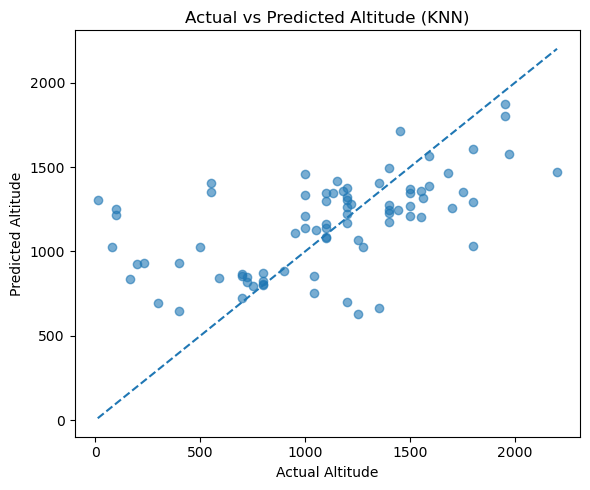

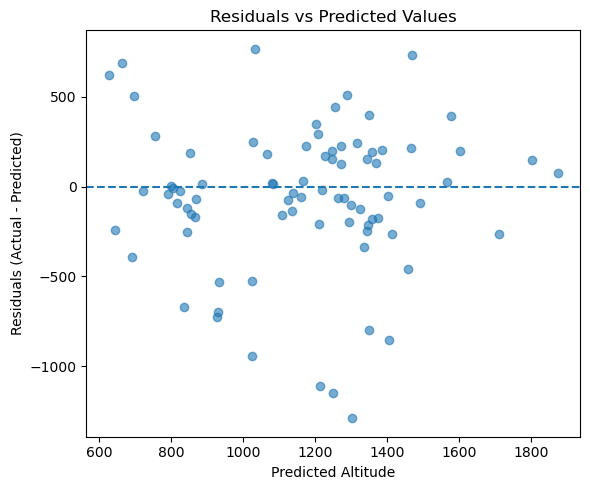

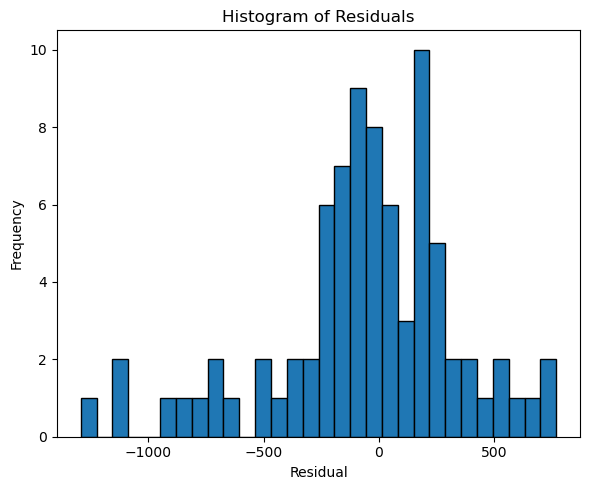

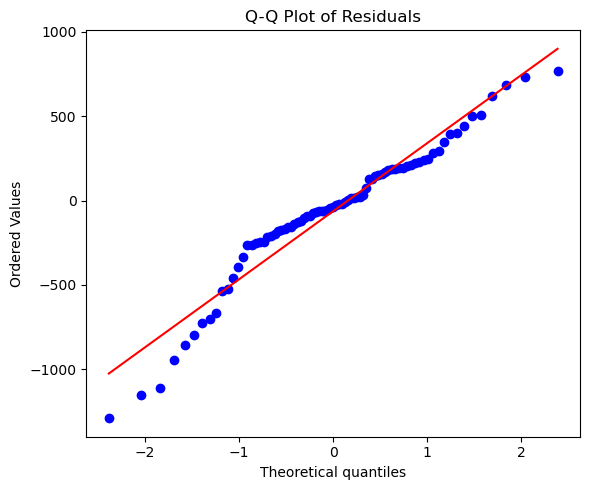

In [11]:
# Convert to numpy arrays (helps with indexing)
y_test_arr = np.array(y_test)
y_pred_arr = np.array(y_pred)

# Residuals
residuals = y_test_arr - y_pred_arr

# 1. Actual vs Predicted
plt.figure(figsize=(6, 5))
plt.scatter(y_test_arr, y_pred_arr, alpha=0.6)
min_val = min(y_test_arr.min(), y_pred_arr.min())
max_val = max(y_test_arr.max(), y_pred_arr.max())
plt.plot([min_val, max_val], [min_val, max_val], linestyle="--")
plt.xlabel("Actual Altitude")
plt.ylabel("Predicted Altitude")
plt.title("Actual vs Predicted Altitude (KNN)")
plt.tight_layout()
plt.show()

# 2. Residuals vs Predicted
plt.figure(figsize=(6, 5))
plt.scatter(y_pred_arr, residuals, alpha=0.6)
plt.axhline(0, linestyle="--")
plt.xlabel("Predicted Altitude")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residuals vs Predicted Values")
plt.tight_layout()
plt.show()

# 3. Histogram of Residuals
plt.figure(figsize=(6, 5))
plt.hist(residuals, bins=30, edgecolor="black")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals")
plt.tight_layout()
plt.show()

# 4. Q-Q Plot of Residuals 
plt.figure(figsize=(6, 5))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.tight_layout()
plt.show()
